<a href="https://colab.research.google.com/github/gongx030/seatac_manuscript/blob/main/notebooks/summarize_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summarize the performance of SeATAC, MACS2 and NucleoATAC on three tasks.

## Background

## Tasks

* Summarize the performance of SeATAC, MACS2 and NucleoATAC on three tasks.
* Explore the relationship between SeATAC performance and BAM quality indices.

## Setup

### Conda

```r421_py37_tf26```

### Install R packages

In [ ]:
required_packages <- c(
  'BiocManager', 'devtools', 'Matrix',
  'dplyr', 'tidyr', 'stringr',
  'pROC', 'parallel'
)

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [ ]:
for (p in required_packages){
  library(p, character.only  = TRUE)
}

Bioconductor version '3.15' is out-of-date; the current release version '3.16'
  is available with R version '4.2'; see https://bioconductor.org/install

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:BiocManager’:

    install


Warning message:
“package ‘Matrix’ was built under R version 4.2.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Warning message:
“package ‘stringr’ was built under R version 4.2.2”
Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




### Install SeATAC from github

In [ ]:
devtools::load_all('../seatac')

ℹ Loading seatac
Loading required package: tensorflow

Warning message:
“package ‘tensorflow’ was built under R version 4.2.2”
Loading required package: tfprobability

Loading required package: tfdatasets

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:pROC’:

    var


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tappl

In [ ]:
#install_github('gongx030/seatac@v0.4.0', force = TRUE, quiet = FALSE)
#reload(pkgload::inst("seatac"))
#library(seatac)

## Parameters

In [ ]:
ARGS <- list(

  remote_metadata_files = c(
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=Maza_version=20221208e/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=qu_version=20221208f/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=Zenere_version=20221115a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=Duren_version=20221116a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=Li_version=20221117a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=knaupp_version=20221118b/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=yagi_version=20221121a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=wu_version=20221121a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=benchetrit_version=20221130a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=melendez_version=20221202a/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=tang_version=20221202c/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=liu2_version=20221202g/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=schwarz_version=20221202e/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=liu_version=20221202d/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=markov_version=20221121b/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=ramirez_version=20221202b/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=denny_version=20221208f/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=zviran_version=20221202f/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=corces_version=20221208g/metadata.tsv',
    'https://s3.msi.umn.edu/gongx030/datasets/dataset=perrin_version=20221208a/metadata.tsv'
  ),

  pct = 0.1, # downsampling percent

  control_seed = 2L,
  positive_seed = 1L,
  negative_seed = 3L,
  
  shift_size = 50L,
  block_size = 640L,
  step_size = 10L,
  counts_max = 20L
)

## Read metadata

In [ ]:
df <- NULL
for (i in 1:length(ARGS[['remote_metadata_files']])){
  local_metadata_file <- gsub('https://', './', ARGS[['remote_metadata_files']][i])
  sprintf('reading %s', ARGS[['remote_metadata_files']][i]) %>% message()
  sprintf('wget -cx %s', ARGS[['remote_metadata_files']][i]) %>% system()
  x <- read.table(local_metadata_file, header = TRUE, sep = '\t')
  df <- rbind(df, cbind(dataset = ARGS[['remote_metadata_files']][i], x))
}

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=Maza_version=20221208e/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=qu_version=20221208f/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=Zenere_version=20221115a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=Duren_version=20221116a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=Li_version=20221117a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=knaupp_version=20221118b/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=yagi_version=20221121a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=wu_version=20221121a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=benchetrit_version=20221130a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/dataset=melendez_version=20221202a/metadata.tsv

reading https://s3.msi.umn.edu/gongx030/datasets/da

In [ ]:
devtools::load_all('../bpt')
df <- df %>%
  filter(type == 'bam') %>%  
  mutate(
    index = row_number(),
    block_size = ARGS[['block_size']],
    step_size = ARGS[['step_size']],
    window_size = ARGS[['window_size']],
    sliding_step = ARGS[['sliding_step']],
    bin_size = ARGS$bin_size,
  ) %>%
  mutate(
  
    local_bam_file = local_file,
    remote_bam_file = remote_file,
    s3_bam_file = s3_file,

    remote_res_full_gt_file = gsub('.bam', '_results_gt.rds', remote_bam_file),
    local_res_full_gt_file = gsub('https://', './', remote_res_full_gt_file),
    s3_res_full_gt_file = gsub('https://s3.msi.umn.edu/', 's3://', remote_res_full_gt_file),

    remote_ds_bam_file = gsub('.bam', sprintf('_seed=%d_pct=%.4f.bam', ARGS$control_seed, ARGS[['pct']]), remote_bam_file),
    local_ds_bam_file = gsub('https://', './', remote_ds_bam_file),
    s3_ds_bam_file = gsub('https://s3.msi.umn.edu/', 's3://', remote_ds_bam_file),

    remote_res_file = gsub('.bam', '_results.rds', remote_ds_bam_file),
    local_res_file = gsub('https://', './', remote_res_file),
    s3_res_file = gsub('https://s3.msi.umn.edu/', 's3://', remote_res_file),

    remote_res_gt_file = gsub('.bam', '_results_gt.rds', remote_ds_bam_file),
    local_res_gt_file = gsub('https://', './', remote_res_gt_file),
    s3_res_gt_file = gsub('https://s3.msi.umn.edu/', 's3://', remote_res_gt_file),

    remote_ds_bam_qc_file = gsub('.bam$', '_qc.json', gsub('.bam', sprintf('_seed=%d_pct=%.4f.bam', ARGS$positive_seed, ARGS$pct), remote_bam_file)),
    local_ds_bam_qc_file = gsub('https://', './', remote_ds_bam_qc_file),
    s3_ds_bam_qc_file = gsub('https://s3.msi.umn.edu/', 's3://', remote_ds_bam_qc_file),

  ) %>%
  mutate(
    local_res_full_gt_file_exist = file.exists(local_res_full_gt_file),
    local_res_file_exist = file.exists(local_res_file),
    local_res_gt_file_exist = file.exists(local_res_gt_file),
    local_ds_bam_qc_file_exist = file.exists(local_ds_bam_qc_file),
  ) 

ℹ Loading bpt
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘bpt’”


In [ ]:
df %>%
  group_by(
    local_res_full_gt_file_exist,
    local_res_file_exist,
    local_res_gt_file_exist,
    local_ds_bam_qc_file_exist,
  ) %>% 
  summarize(n())

`summarise()` has grouped output by 'local_res_full_gt_file_exist', 'local_res_file_exist', 'local_res_gt_file_exist'. You can override using
the `.groups` argument.


local_res_full_gt_file_exist,local_res_file_exist,local_res_gt_file_exist,local_ds_bam_qc_file_exist,n()
<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,3
FALSE,FALSE,FALSE,TRUE,278
FALSE,TRUE,FALSE,TRUE,3
FALSE,TRUE,TRUE,TRUE,4
TRUE,FALSE,FALSE,TRUE,100
TRUE,TRUE,TRUE,FALSE,1
TRUE,TRUE,TRUE,TRUE,523


## Download remote files

In [ ]:
#devtools::load_all('../bpt')
#df %>%
#  mutate(download_remote_file(remote_file))

## Find IDs for jobs

In [ ]:
devtools::load_all('../bpt')
df_jobs <- df %>%
  filter(    
    local_res_full_gt_file_exist &
    local_res_file_exist & 
    local_res_gt_file_exist &
    local_ds_bam_qc_file_exist
  )

ℹ Loading bpt
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘bpt’”


In [ ]:
sprintf('# jobs: %d', nrow(df_jobs)) %>% message()

# jobs: 523



## Computing metrics

In [ ]:
params <- expand.grid(
  counts_cutoff = c(0:50),
  i = 1:nrow(df_jobs)
)

In [ ]:
j <- 1
df <- do.call('rbind', mclapply(1:nrow(params), function(j){

  sprintf('%d/%d i=%d counts_cutoff=%d', j, nrow(params), params[j, 'i'], params[j, 'counts_cutoff']) %>% message()

  qc <- fromJSON(file = df_jobs[params[j, 'i'], 'local_ds_bam_qc_file'])

  res <- readRDS(df_jobs[params[j, 'i'], 'local_res_file'])
  res <- res[res$counts[, 1] >= params[j, 'counts_cutoff']]
  if (length(res) > 0 && length(unique(res$class)) > 1){
    roc_seatac_task1 <- roc(res$class, res$pvalue_z, quiet = TRUE)$auc # differential V-plots as estimated by the SeATAC p-value
    roc_macs2_task1 <- roc(res$class, res$macs2_block, quiet = TRUE)$auc # differential V-plots as estimated by maximum MACS2 difference between samples
    roc_nucleoatac_task1 <- roc(res$class, res$nucleoatac_block, quiet = TRUE)$auc
  }else{
    roc_seatac_task1 <- NA
    roc_macs2_task1 <- NA
    roc_nucleoatac_task1 <- NA
  }
  n_task1 <- length(res)

  res_nuc <- readRDS(df_jobs[params[j, 'i'], 'local_res_full_gt_file'])
  res_nuc <- res_nuc[res_nuc$counts[, 1] >= params[j, 'counts_cutoff']]
  if (length(res_nuc) > 0 && length(unique(res_nuc$is_nucleosome)) > 1){
    roc_nuc_seatac_full_task2 <- roc(res_nuc$is_nucleosome, res_nuc$nucleosome_control, quiet = TRUE)$auc # nucleosome calling
    roc_nuc_nucleoatac_full_task2 <- roc(res_nuc$is_nucleosome, res_nuc$nucleoatac_center, quiet = TRUE)$auc
  }else{
    roc_nuc_seatac_full_task2 <- NA
    roc_nuc_nucleoatac_full_task2 <- NA
  }
  n_task2 <- length(res_nuc)

  res_nuc <- readRDS(df_jobs[params[j, 'i'], 'local_res_gt_file'])
  res_nuc <- res_nuc[res_nuc$counts[, 1] >= params[j, 'counts_cutoff']]
  if (length(res_nuc) > 0 && length(unique(res_nuc$class)) > 1){
    roc_nuc_seatac_task3 <- roc(res_nuc$class, res_nuc$log_ratio, quiet = TRUE)$auc # difference between center regions
    roc_nuc_nucleoatac_task3 <- roc(res_nuc$class, res_nuc$nucleoatac_center_diff, quiet = TRUE)$auc
  }else{
    roc_nuc_seatac_task3 <- NA
    roc_nuc_nucleoatac_task3 <- NA
  }
  n_task3 <- length(res_nuc)

  d <- rbind(
    data.frame(method = 'seatac', group = 'random', task = 1, roc = roc_seatac_task1, n = n_task1),
    data.frame(method = 'macs2', group = 'random', task = 1, roc = roc_macs2_task1, n = n_task1),
    data.frame(method = 'nucleoatac', group = 'random', task = 1, roc = roc_nucleoatac_task1, n = n_task1),

    data.frame(method = 'seatac', group = 'nucleosome', task = 2, roc = roc_nuc_seatac_full_task2, n = n_task2),
    data.frame(method = 'nucleoatac', group = 'nucleosome', task = 2, roc = roc_nuc_nucleoatac_full_task2, n = n_task2),

    data.frame(method = 'seatac', group = 'nucleosome', task = 3, roc = roc_nuc_seatac_task3, n = n_task3),
    data.frame(method = 'nucleoatac', group = 'nucleosome', task = 3, roc = roc_nuc_nucleoatac_task3, n = n_task3)
  )
  cbind(
    local_ds_bam_file = df_jobs[i, 'local_ds_bam_file'], 
    counts_cutoff = params[j, 'counts_cutoff'], 
    as.data.frame(qc[c('totalQNAMEs','mitochondriaRate','properPairRate','unmappedRate','hasUnmappedMateRate','nonRedundantFraction','PCRbottleneckCoefficient_1','PCRbottleneckCoefficient_2')]), 
    d
  )
}, mc.cores = 8, mc.preschedule = TRUE))

In [ ]:
df <- df %>%
  mutate(roc = as.numeric(roc)) %>%
  mutate(roc = if_else(roc > 1, 1, roc))

## Task 1: Detecting differential V-plots

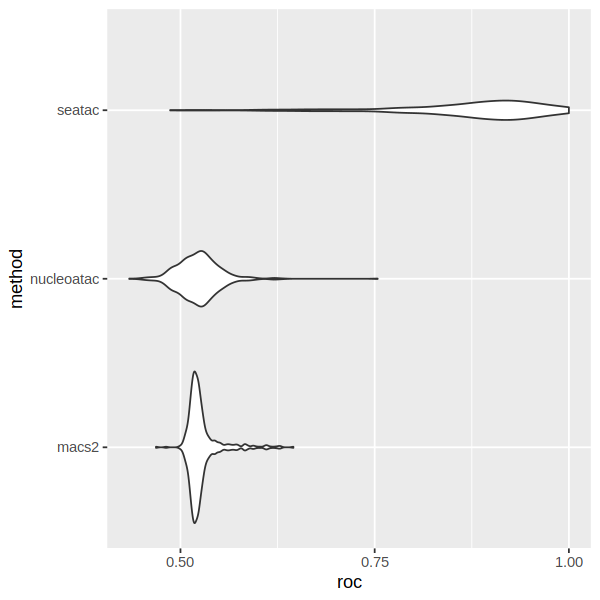

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
df %>%
  filter(group == 'random' & counts_cutoff == 0) %>%
  mutate(method = factor(method, c('macs2', 'nucleoatac', 'seatac'))) %>%
  ggplot(aes(x = method, y = roc)) +
    geom_violin(trim=TRUE)  +
    coord_flip() +
    scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('mean AUC seatac: %.3f', mean(df$roc[df$group == 'random' & df$method == 'seatac' & df$counts_cutoff == 0])) %>% message()
sprintf('mean AUC nucleoatac: %.3f', mean(df$roc[df$group == 'random' & df$method == 'nucleoatac' & df$counts_cutoff == 0])) %>% message()
sprintf('Wilcox test p-value: %.5e', wilcox.test(df$roc[df$group == 'random' & df$method == 'seatac' & df$counts_cutoff == 0], df$roc[df$group == 'random' & df$method == 'nucleoatac' & df$counts_cutoff == 0], alternative = 'greater')$p.value) %>% message()

mean AUC seatac: 0.876

mean AUC nucleoatac: 0.523

Wilcox test p-value: 2.99044e-167



In [ ]:
sprintf('mean AUC seatac: %.3f', mean(df$roc[df$group == 'random' & df$method == 'seatac' & df$counts_cutoff == 0])) %>% message()
sprintf('mean AUC macs2: %.3f', mean(df$roc[df$group == 'random' & df$method == 'macs2' & df$counts_cutoff == 0])) %>% message()
sprintf('Wilcox test p-value: %.5e', wilcox.test(df$roc[df$group == 'random' & df$method == 'seatac' & df$counts_cutoff == 0], df$roc[df$group == 'random' & df$method == 'macs2' & df$counts_cutoff == 0], alternative = 'greater')$p.value) %>% message()

mean AUC seatac: 0.876

mean AUC macs2: 0.527

Wilcox test p-value: 2.76320e-167



`summarise()` has grouped output by 'counts_cutoff'. You can override using the `.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


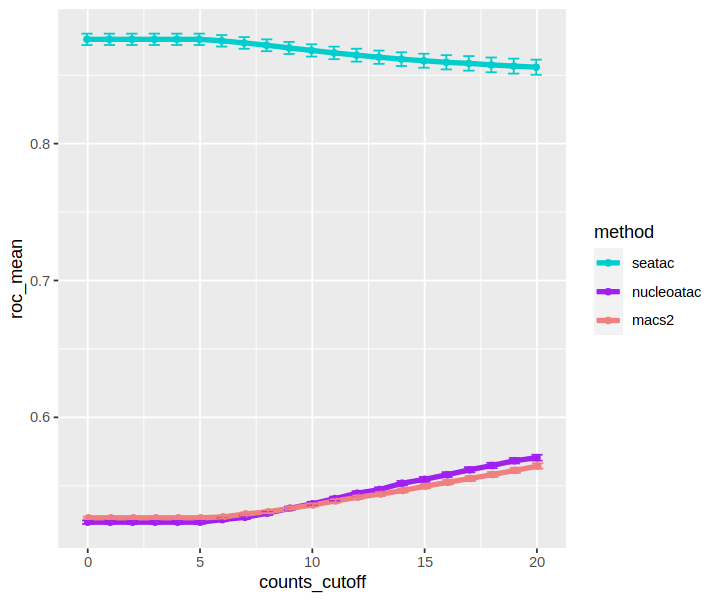

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
df %>%
  filter(group == 'random' & counts_cutoff >= 0 & counts_cutoff <= ARGS$counts_max) %>%
  mutate(method = factor(method, c('seatac', 'nucleoatac', 'macs2'))) %>%
  group_by(counts_cutoff, method) %>%
  summarize(roc_mean = mean(roc, na.rm = TRUE), roc_std = sd(roc, na.rm = TRUE) / sqrt(n())) %>%
  ggplot(aes(x = counts_cutoff, y = roc_mean, color = method)) +
    geom_line(size = 1.5, position = position_dodge(0.1))  +
    geom_point(size = 1.5, position = position_dodge(0.1)) +
    geom_errorbar(aes(ymin = roc_mean - roc_std, ymax = roc_mean + roc_std), width = 1.5, position = position_dodge(0.1)) +
    scale_y_continuous() + 
    scale_color_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    scale_fill_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3'))

## Task 2: Calling nucleosomes

Warning message:
“Removed 4 rows containing non-finite values (`stat_ydensity()`).”


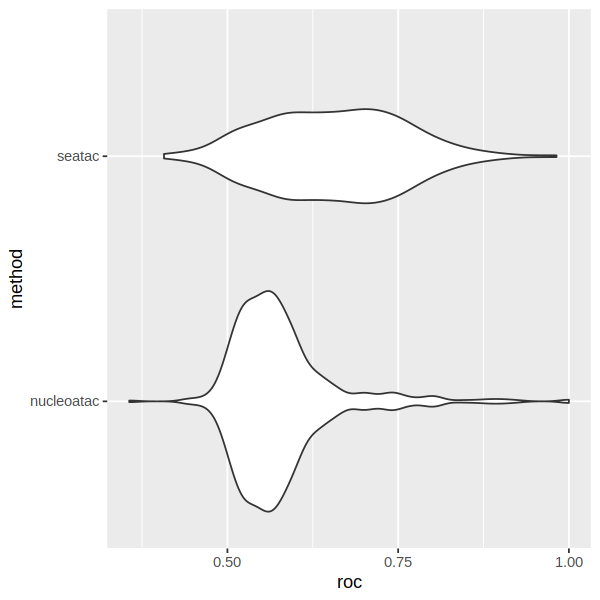

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
df %>%
  filter(group == 'nucleosome' & task == 2 & counts_cutoff == 0) %>%
  mutate(method = factor(method, c('macs2', 'nucleoatac', 'seatac'))) %>%
  ggplot(aes(x = method, y = roc)) +
    geom_violin(trim=TRUE)  +
    coord_flip() +
    scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
df$roc[df$group == 'nucleosome' & df$task == 2 & df$method == 'seatac' & df$counts_cutoff == 0] %>% is.na() %>% any()

[1] TRUE

In [ ]:
sprintf('mean AUC seatac: %.3f', mean(df$roc[df$group == 'nucleosome' & df$task == 2 & df$method == 'seatac' & df$counts_cutoff == 0], na.rm = TRUE)) %>% message()
sprintf('mean AUC nucleoatac: %.3f', mean(df$roc[df$group == 'nucleosome' & df$task == 2 & df$method == 'nucleoatac' & df$counts_cutoff == 0], na.rm = TRUE)) %>% message()
sprintf('Wilcox test p-value: %.5e', wilcox.test(df$roc[df$group == 'nucleosome' & df$task == 2 & df$method == 'seatac' & df$counts_cutoff == 0], df$roc[df$group == 'nucleosome' & df$task == 2 & df$method == 'nucleoatac' & df$counts_cutoff == 0], alternative = 'greater')$p.value) %>% message()

mean AUC seatac: 0.656

mean AUC nucleoatac: 0.578

Wilcox test p-value: 1.58868e-42



`summarise()` has grouped output by 'counts_cutoff'. You can override using the `.groups` argument.
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


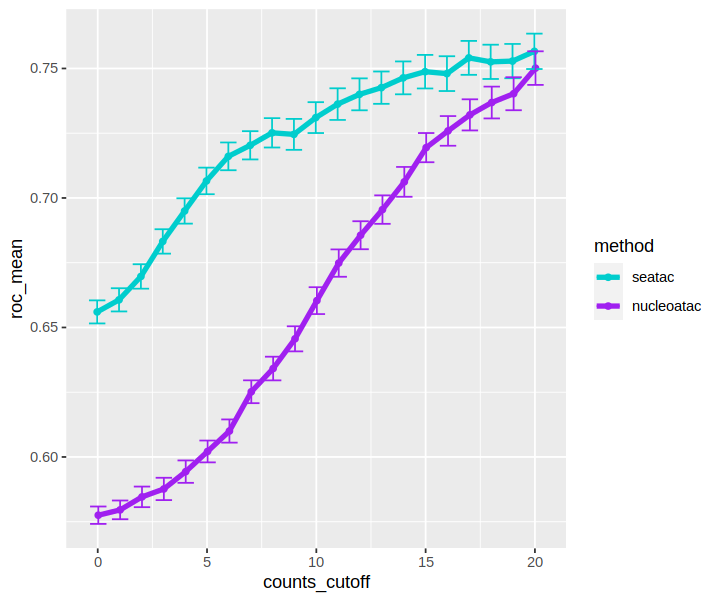

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
df %>%
  filter(group == 'nucleosome' & task == 2 & counts_cutoff >= 0 & counts_cutoff <= ARGS$counts_max) %>%
  mutate(method = factor(method, c('seatac', 'nucleoatac', 'macs2'))) %>%
  group_by(counts_cutoff, method) %>%
  summarize(roc_mean = mean(roc, na.rm = TRUE), roc_std = sd(roc, na.rm = TRUE) / sqrt(n())) %>%
  ggplot(aes(x = counts_cutoff, y = roc_mean, color = method)) +
    geom_line(size = 1.5, position = position_dodge(0.1))  +
    geom_point(size = 1.5, position = position_dodge(0.1)) +
    geom_errorbar(aes(ymin = roc_mean - roc_std, ymax = roc_mean + roc_std), width = 1.5, position = position_dodge(0.1)) +
    scale_y_continuous() + #breaks = seq(0, 1, by = 0.25)) +
    scale_color_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    scale_fill_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3'))

## Task 3: Detecting differential nucleosomes

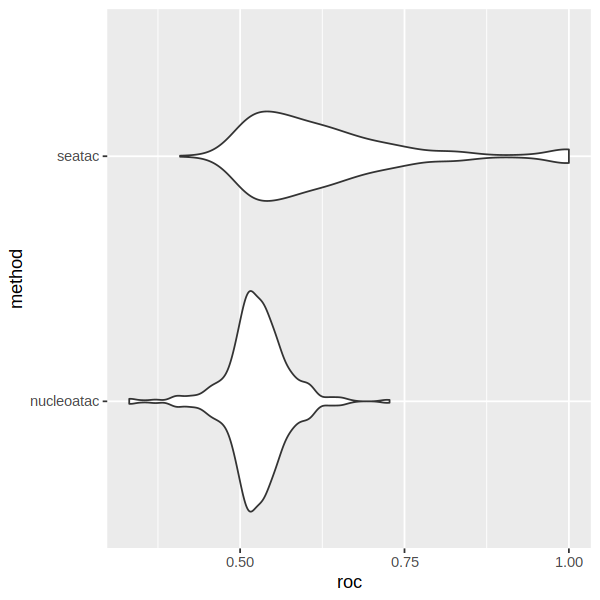

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
df %>%
  filter(group == 'nucleosome' & task == 3 & counts_cutoff == 0) %>%
  mutate(method = factor(method, c('macs2', 'nucleoatac', 'seatac'))) %>%
  ggplot(aes(x = method, y = roc)) +
    geom_violin(trim=TRUE)  +
    coord_flip() +
    scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('mean AUC seatac: %.3f', mean(df$roc[df$group == 'nucleosome' & df$task == 3 & df$method == 'seatac' & df$counts_cutoff == 0])) %>% message()
sprintf('mean AUC nucleoatac: %.3f', mean(df$roc[df$group == 'nucleosome' & df$task == 3 & df$method == 'nucleoatac' & df$counts_cutoff == 0])) %>% message()
sprintf('Wilcox test p-value: %.5e', wilcox.test(df$roc[df$group == 'nucleosome' & df$task == 3 & df$method == 'seatac' & df$counts_cutoff == 0], df$roc[df$group == 'nucleosome' & df$task == 3 & df$method == 'nucleoatac' & df$counts_cutoff == 0], alternative = 'greater')$p.value) %>% message()

mean AUC seatac: 0.625

mean AUC nucleoatac: 0.526

Wilcox test p-value: 2.97196e-59



`summarise()` has grouped output by 'counts_cutoff'. You can override using the `.groups` argument.
Warning message:
“`position_dodge()` requires non-overlapping x intervals”


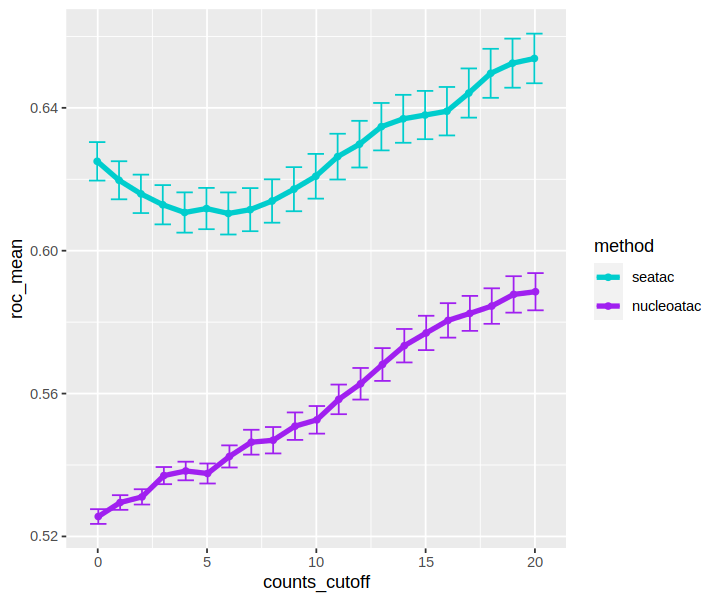

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
df %>%
  filter(group == 'nucleosome' & task == 3 & counts_cutoff >= 0 & counts_cutoff <= ARGS$counts_max) %>%
  mutate(method = factor(method, c('seatac', 'nucleoatac', 'macs2'))) %>%
  group_by(counts_cutoff, method) %>%
  summarize(roc_mean = mean(roc, na.rm = TRUE), roc_std = sd(roc, na.rm = TRUE) / sqrt(n())) %>%
  ggplot(aes(x = counts_cutoff, y = roc_mean, color = method)) +
    geom_line(size = 1.5, position = position_dodge(0.1))  +
    geom_point(size = 1.5, position = position_dodge(0.1)) +
    geom_errorbar(aes(ymin = roc_mean - roc_std, ymax = roc_mean + roc_std), width = 1.5, position = position_dodge(0.1)) +
    scale_y_continuous() + #breaks = seq(0, 1, by = 0.1)) +
    scale_color_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3')) +
    scale_fill_manual(values= c(macs2 = 'lightcoral', nucleoatac = 'purple', seatac = 'cyan3'))

## Relationship between SeATAC performance and BAM quality indices

### totalQNAMEs

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


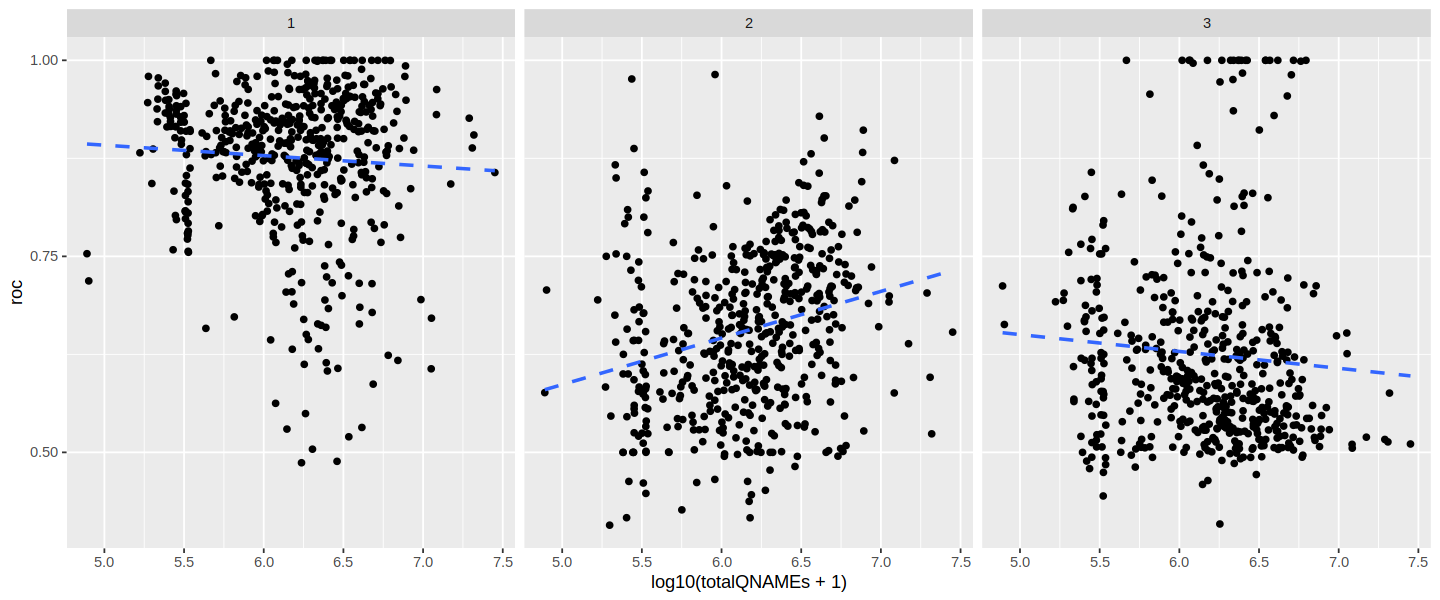

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = log10(totalQNAMEs + 1), y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ log10(totalQNAMEs + 1), df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ log10(totalQNAMEs + 1), df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ log10(totalQNAMEs + 1), df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 1.678e-01

Task 2 p-value: 5.185e-09

Task 3 p-value: 8.503e-02



### mitochondriaRate

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


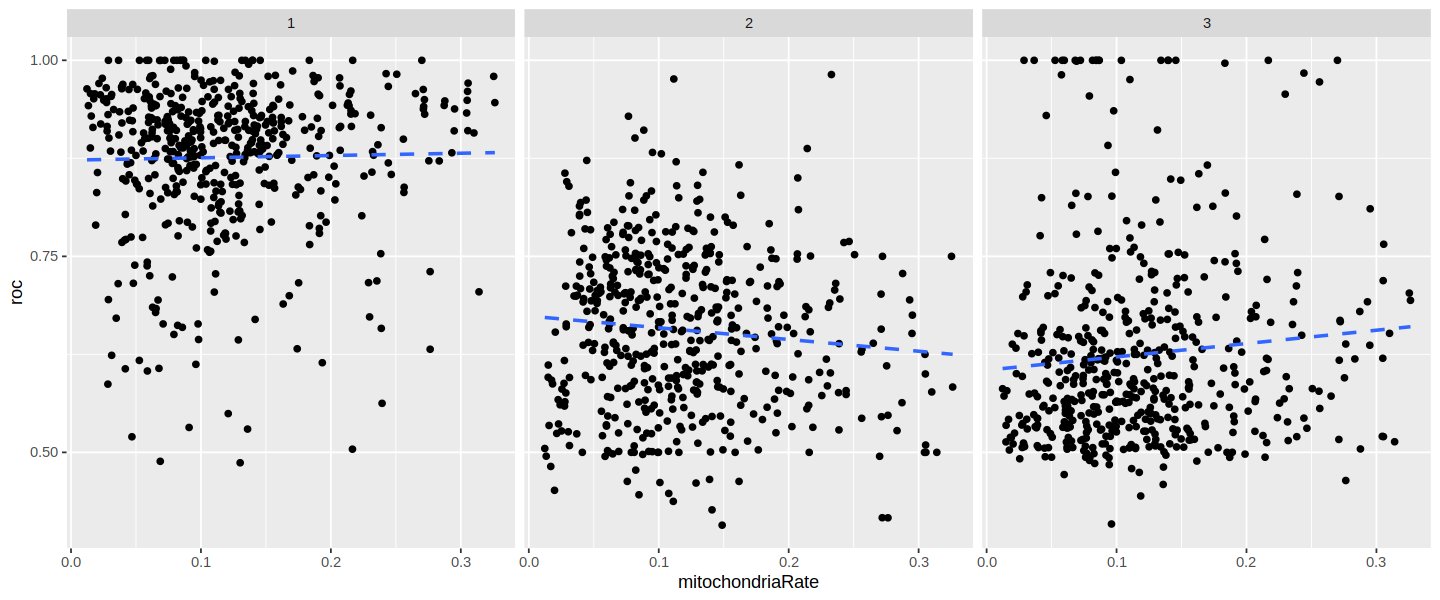

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = mitochondriaRate, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ mitochondriaRate, df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ mitochondriaRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ mitochondriaRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 6.416e-01

Task 2 p-value: 2.617e-02

Task 3 p-value: 3.617e-02



### properPairRate

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


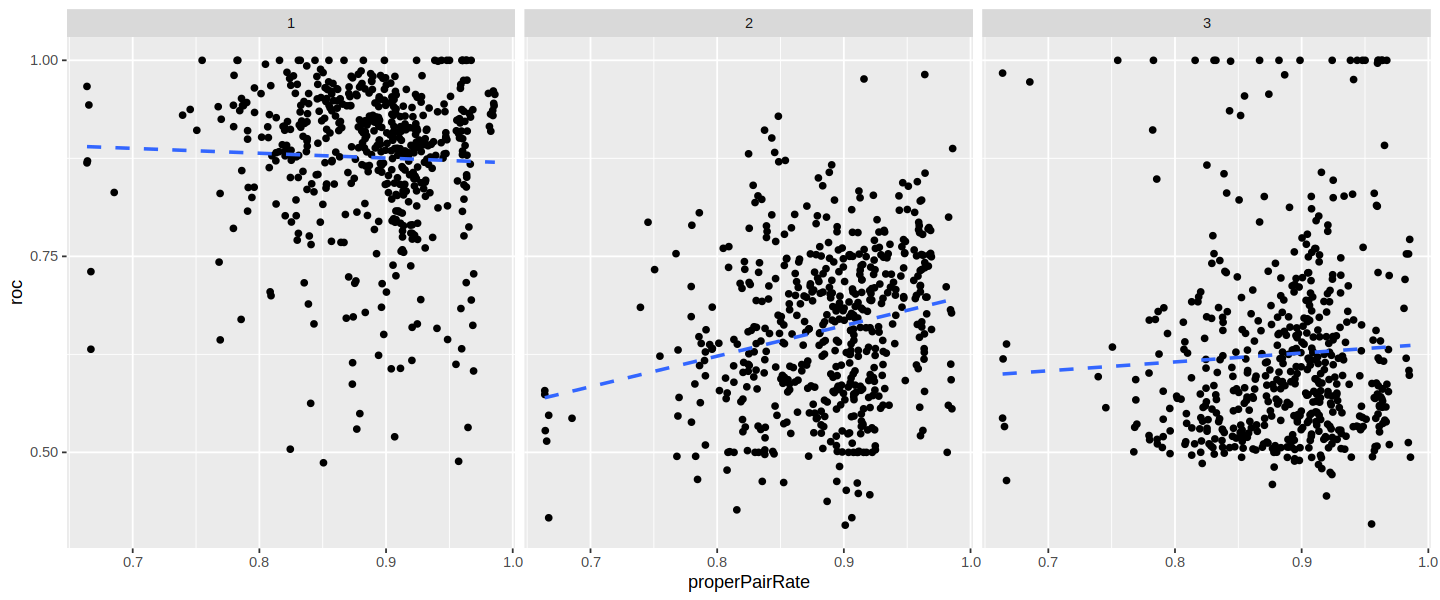

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = properPairRate, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ properPairRate, df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ properPairRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ properPairRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 4.010e-01

Task 2 p-value: 5.998e-07

Task 3 p-value: 2.359e-01



### unmappedRate

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


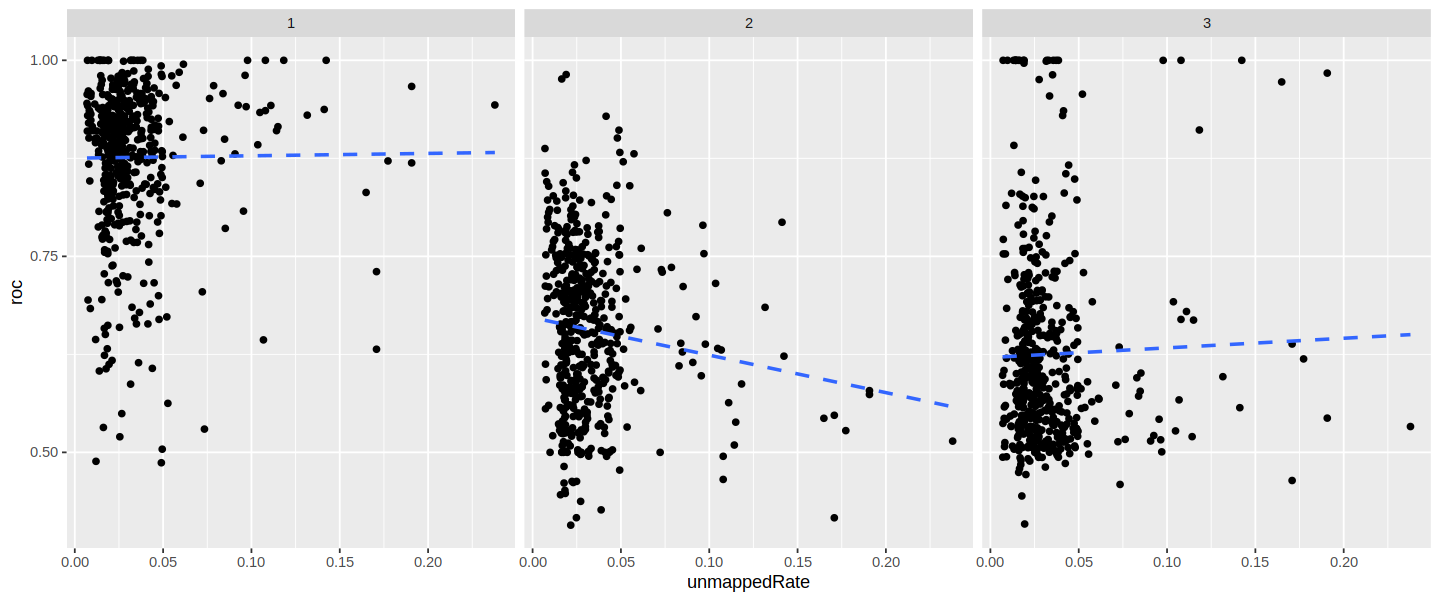

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = unmappedRate, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ unmappedRate, df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ unmappedRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ unmappedRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 8.452e-01

Task 2 p-value: 3.836e-03

Task 3 p-value: 5.411e-01



### hasUnmappedMateRate

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


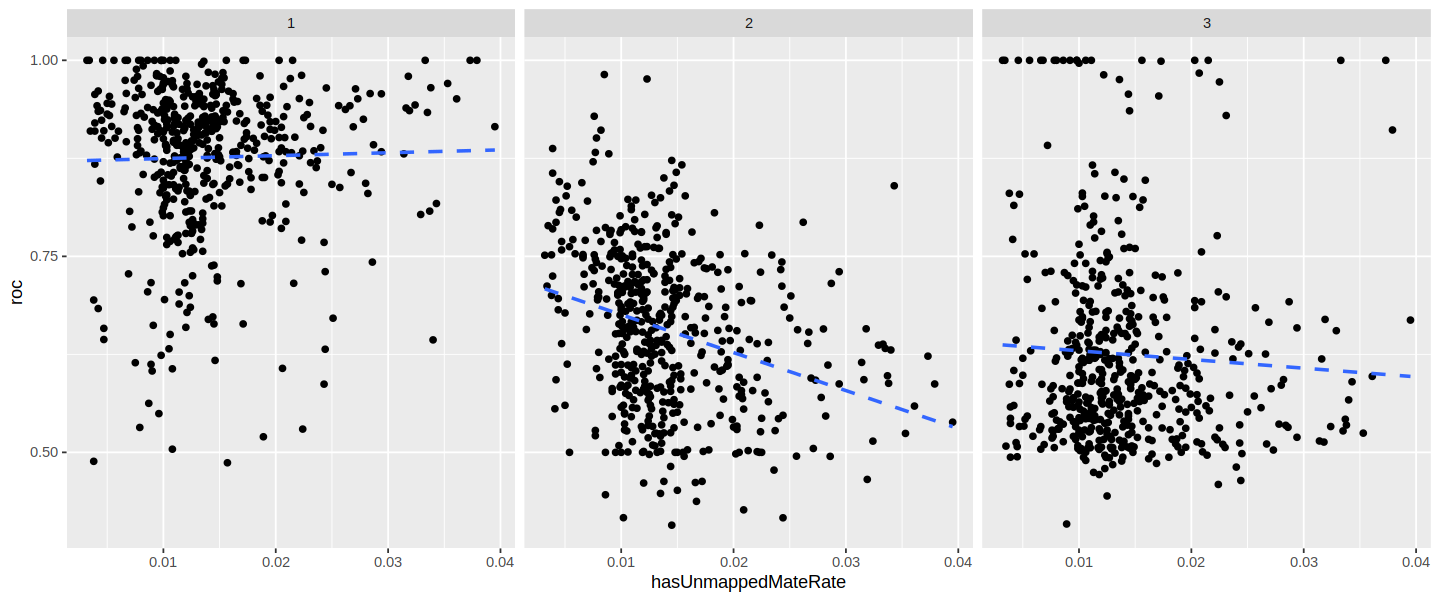

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = hasUnmappedMateRate, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ hasUnmappedMateRate, df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ hasUnmappedMateRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ hasUnmappedMateRate, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 5.773e-01

Task 2 p-value: 2.409e-12

Task 3 p-value: 1.957e-01



### nonRedundantFraction

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


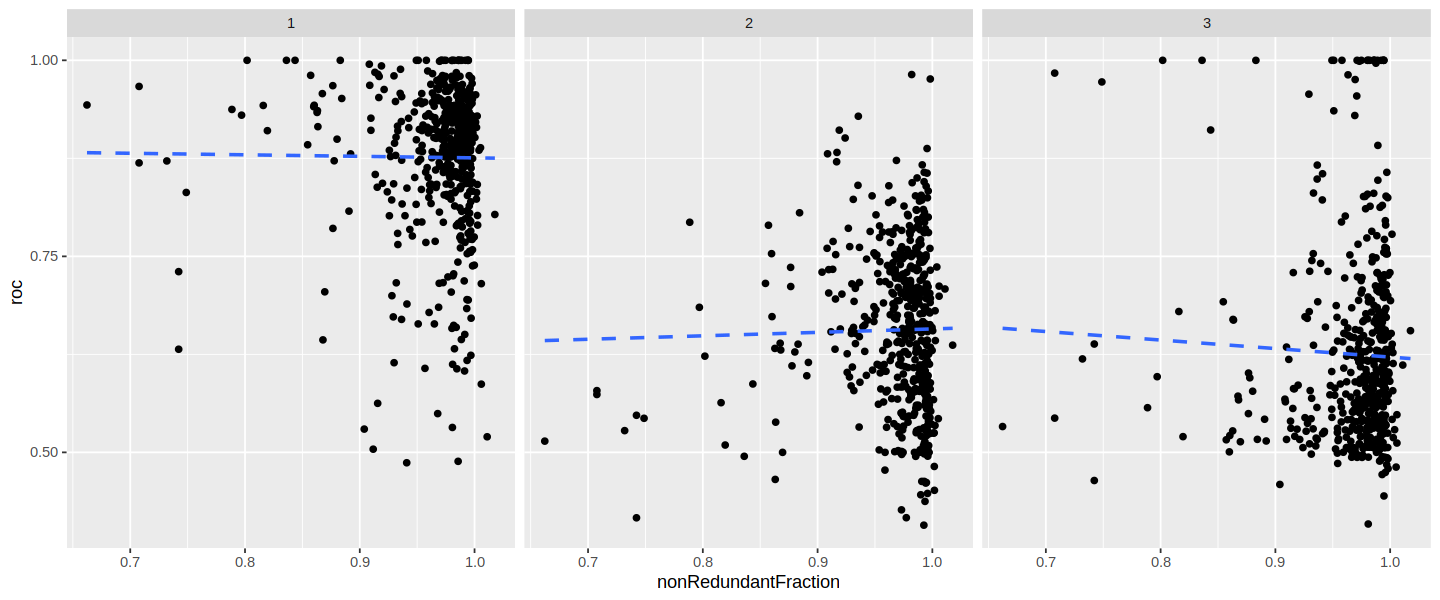

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = nonRedundantFraction, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ nonRedundantFraction, df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ nonRedundantFraction, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ nonRedundantFraction, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 8.346e-01

Task 2 p-value: 6.612e-01

Task 3 p-value: 3.704e-01



### PCRbottleneckCoefficient_1

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


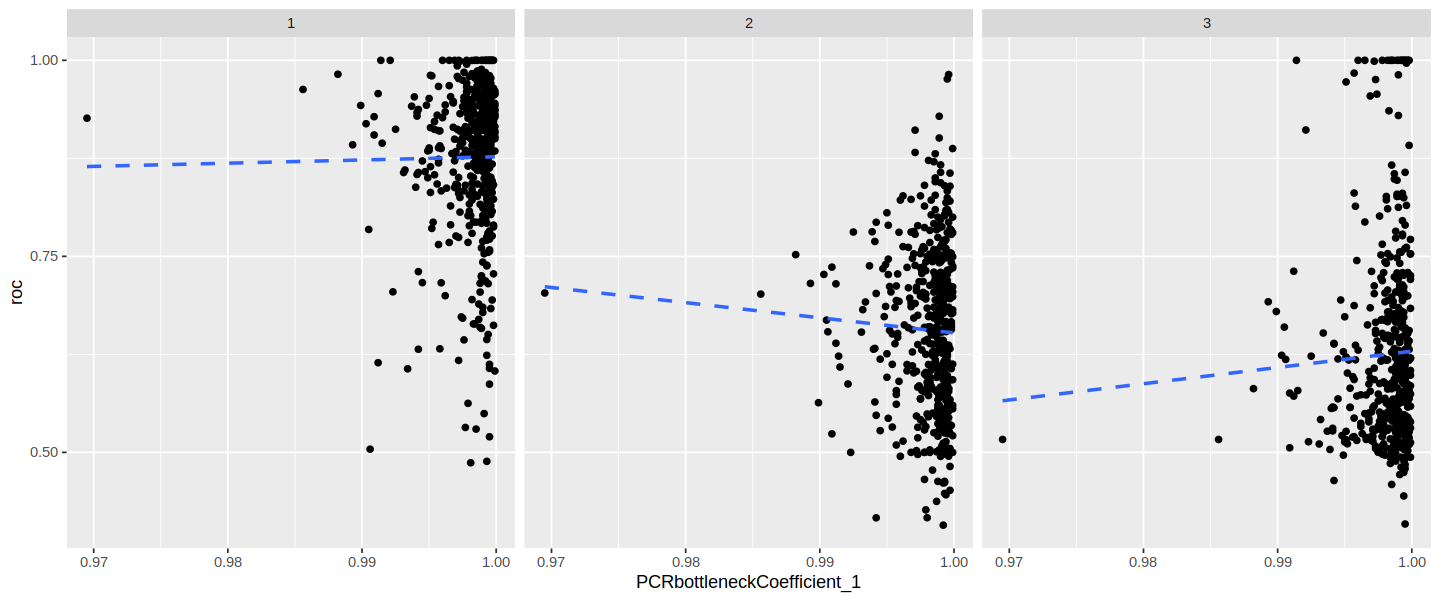

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    ggplot(aes(x = PCRbottleneckCoefficient_1, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ PCRbottleneckCoefficient_1, df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ PCRbottleneckCoefficient_1, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ PCRbottleneckCoefficient_1, df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 8.200e-01

Task 2 p-value: 3.151e-01

Task 3 p-value: 3.732e-01



### PCRbottleneckCoefficient_2

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


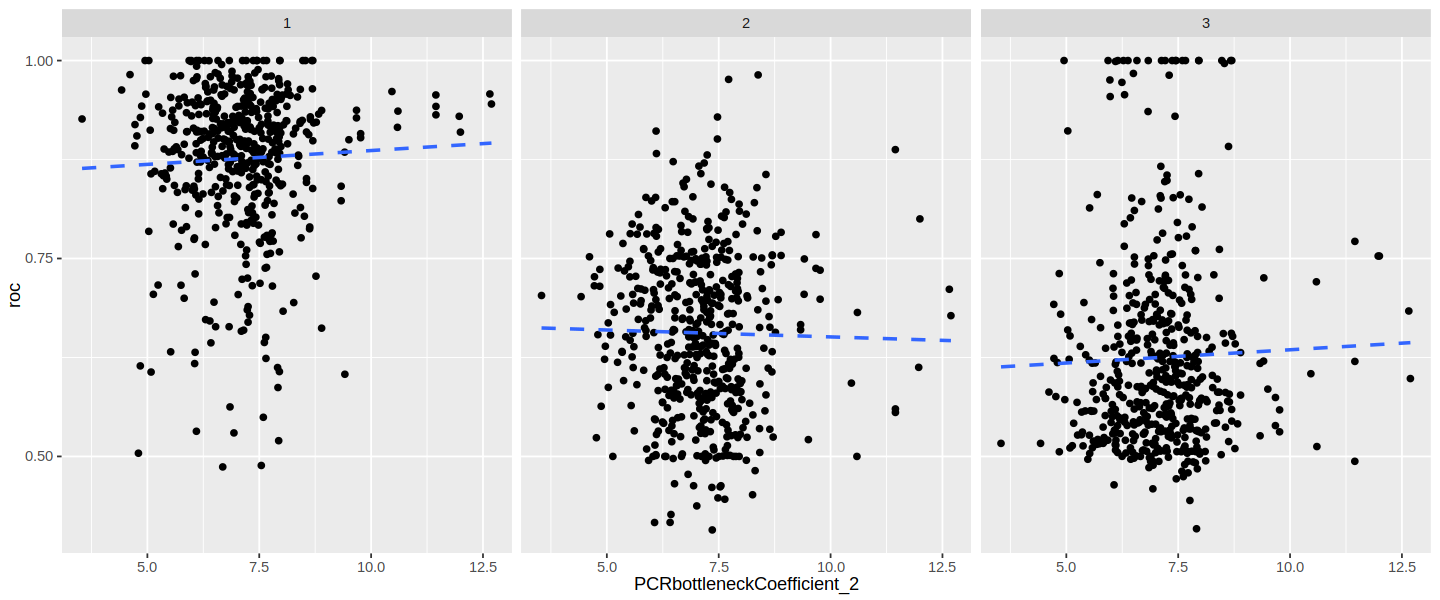

In [ ]:
options(repr.plot.width=12, repr.plot.height=5)
df %>%
  filter(
    (method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0) |
    (method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)   
  ) %>%
    mutate(roc = as.numeric(roc)) %>%
    mutate(PCRbottleneckCoefficient_2 = log(PCRbottleneckCoefficient_2 + 1)) %>%
    ggplot(aes(x = PCRbottleneckCoefficient_2, y = roc)) + 
      geom_point() +
      geom_smooth(method = "lm", fill = NA, se = TRUE, linetype = "dashed") +
      facet_grid(. ~ task) +
      scale_y_continuous(breaks = seq(0, 1, by = 0.25))

In [ ]:
sprintf('Task 1 p-value: %.3e', summary(lm(roc ~ log(PCRbottleneckCoefficient_2 + 1), df %>% filter(method == 'seatac' & group == 'random' & task == 1 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 2 p-value: %.3e', summary(lm(roc ~ log(PCRbottleneckCoefficient_2 + 1), df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 2 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()
sprintf('Task 3 p-value: %.3e', summary(lm(roc ~ log(PCRbottleneckCoefficient_2 + 1), df %>% filter(method == 'seatac' & group == 'nucleosome' & task == 3 & counts_cutoff == 0)))$coefficients[2, 4]) %>% message()

Task 1 p-value: 3.397e-01

Task 2 p-value: 6.574e-01

Task 3 p-value: 4.813e-01



## SessionInfo

In [ ]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /panfs/jay/groups/18/garrydj/gongx030/.conda/envs/r421_py37_tf26/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] bpt_0.1.005                 seatac_0.4.2-002           
 [3] SummarizedExperiment_1.26.1 Biobase_2.56.0             
 [5] MatrixGenerics_1.8.1        matrixStats_0.63.0         
 [7] GenomicRanges_1.48.0        GenomeInfoDb_1.32.4        
 [9]